In [1]:
import pandas as pd
import numpy as np

np.random.seed(0)

## Generate fake weather Data

In [36]:
def compute_solar_irradiance(solar_time):
    phi = 0.68
    delta = 0.401
    return 1361 * (
        np.sin(phi) * np.sin(delta)
        + np.cos(phi) * np.cos(delta) * np.cos(solar_time * np.pi / 12)
    )

<Axes: >

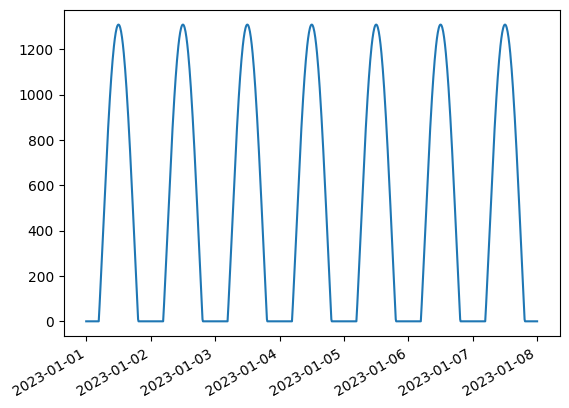

In [38]:
solar_irradiance = pd.DataFrame(
    index=pd.date_range(start="2023-01-01", end="2023-01-08", freq="10min")
    + pd.Timedelta(np.random.normal(0, 5), unit="min")
)

solar_irradiance["solar_time"] = (
    solar_irradiance.index.to_series().dt.hour
    + solar_irradiance.index.to_series().dt.minute / 60
) - 12
solar_irradiance["power"] = compute_solar_irradiance(solar_irradiance["solar_time"])
solar_irradiance.loc[solar_irradiance["power"] < 0, "power"] = 0
solar_irradiance["power"].plot()

## Generate fake solar Data

<Axes: >

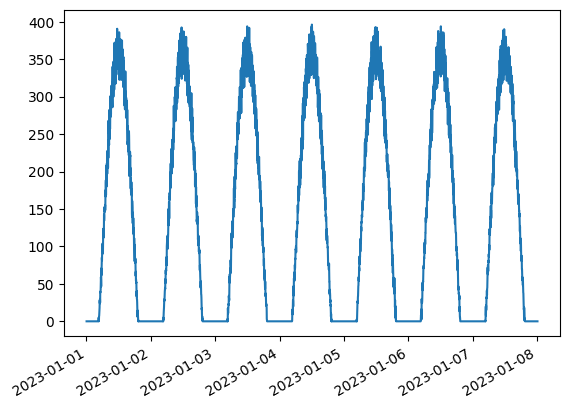

In [40]:

solar_power = pd.DataFrame(
    index=pd.date_range(start="2023-01-01", end="2023-01-08", freq="3min")
    + pd.Timedelta(np.random.normal(0, 5), unit="min")
)

solar_power["solar_time"] = (
    solar_power.index.to_series().dt.hour
    + solar_power.index.to_series().dt.minute / 60
) - 12
solar_power["power"] = np.random.uniform(0.25, 0.3, size=solar_power.index.size) * compute_solar_irradiance(solar_power["solar_time"]) + np.random.normal(0, 5, size=solar_power.index.size)
solar_power.loc[solar_power["power"] < 0, "power"] = 0
solar_power["power"].plot()

## Merge the two data sources

In [49]:
df = pd.merge(solar_irradiance['power'], solar_power['power'], left_index=True, right_index=True, suffixes=('_sun', '_panel'), how='outer')
df

,power_sun,power_panel
2022-12-31 23:58:10.523237796,0.0,NaN
2023-01-01 00:06:18.082326216,NaN,0.0
2023-01-01 00:08:10.523237796,0.0,NaN
2023-01-01 00:09:18.082326216,NaN,0.0
2023-01-01 00:12:18.082326216,NaN,0.0
...,...,...
2023-01-07 23:57:18.082326216,NaN,0.0
2023-01-07 23:58:10.523237796,0.0,NaN
2023-01-08 00:00:18.082326216,NaN,0.0
2023-01-08 00:03:18.082326216,NaN,0.0


## Using Intervals

If we are only interested in the mean power during the day, we need to trim the 'power_panel' data only times during the day.


In [54]:
from pandas_timeinterval import Intervals

df_trimmed = (
    Intervals.from_bool_series(df['power_sun'].dropna() > 0)
    .contract(pd.Timedelta("1h"))
    .trim(df)
)
df_trimmed['power_panel'].plot()

,power_sun,power_panel
2023-01-01 05:48:10.523237796,283.055131,NaN
2023-01-01 05:48:18.082326216,NaN,85.292880
2023-01-01 05:51:18.082326216,NaN,81.517220
2023-01-01 05:54:18.082326216,NaN,92.096396
2023-01-01 05:57:18.082326216,NaN,92.090441
...,...,...
2023-01-07 18:08:10.523237796,300.043902,NaN
2023-01-07 18:09:18.082326216,NaN,80.924234
2023-01-07 18:12:18.082326216,NaN,87.618308
2023-01-07 18:15:18.082326216,NaN,81.353498


In [57]:
df['power_panel'].mean(), df_trimmed['power_panel'].mean()

(np.float64(136.14318808085105), np.float64(255.01787439946813))